# 필요 라이브러리 import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# 데이터 가져오기

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
train_dataset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# GAN구현(Generator, Discriminator, train)

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

In [5]:
def train_gan(generator, discriminator, dataloader, epochs=50, latent_dim=100, lr=0.0002):
    generator.to(device)
    discriminator.to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    G_loss = []
    D_loss = []

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)

            real_labels = torch.ones(batch_size, 1, device=device) # 실제 이미지 라벨 설정
            fake_labels = torch.zeros(batch_size, 1, device=device) # 가짜 이미지 라벨 설정

            total_loss_G = 0
            total_loss_D = 0

            real_images = real_images.to(device)
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images) # 진짜 이미지를 이용한 discriminator학습
            loss_real = criterion(real_outputs, real_labels)

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise) # noise를 통한 가짜 이미지 생성
            fake_outputs = discriminator(fake_images.detach()) # 가짜 이미지를 이용한 discriminator학습
            loss_fake = criterion(fake_outputs, fake_labels)

            loss_D = loss_real + loss_fake # 전체 Loss = 진짜, 가짜 이미지의 discriminator Loss의 합
            loss_D.backward()
            optimizer_D.step() # discriminator학습

            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images) # 이후 가짜 이미지를 다시 discriminator에 넣고
            loss_G = criterion(fake_outputs, real_labels)
            loss_G.backward()
            optimizer_G.step() # generator학습
            
            total_loss_G += loss_G.item()
            total_loss_D += loss_D.item()

        # 에포크별 평균 손실 저장
        G_loss.append(total_loss_G / len(dataloader))
        D_loss.append(total_loss_D / len(dataloader))
            
        print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    return G_loss, D_loss

In [6]:
gen = Generator()
dis = Discriminator()
gan_Gloss, gan_Dloss = train_gan(gen, dis, train_loader, epochs=100, latent_dim=100, lr=0.0002)

Epoch [1/100] Loss_D: 1.0743 Loss_G: 2.1129
Epoch [2/100] Loss_D: 0.7324 Loss_G: 2.3694
Epoch [3/100] Loss_D: 0.8257 Loss_G: 3.6401
Epoch [4/100] Loss_D: 0.5925 Loss_G: 4.3982
Epoch [5/100] Loss_D: 0.6511 Loss_G: 2.2574
Epoch [6/100] Loss_D: 0.8636 Loss_G: 3.4074
Epoch [7/100] Loss_D: 0.1396 Loss_G: 3.6119
Epoch [8/100] Loss_D: 0.4298 Loss_G: 2.8770
Epoch [9/100] Loss_D: 0.2669 Loss_G: 3.4732
Epoch [10/100] Loss_D: 0.5792 Loss_G: 4.4474
Epoch [11/100] Loss_D: 0.2081 Loss_G: 2.1357
Epoch [12/100] Loss_D: 0.1917 Loss_G: 3.7608
Epoch [13/100] Loss_D: 0.7005 Loss_G: 5.9438
Epoch [14/100] Loss_D: 2.9538 Loss_G: 0.1771
Epoch [15/100] Loss_D: 0.1814 Loss_G: 3.4405
Epoch [16/100] Loss_D: 0.2407 Loss_G: 5.8379
Epoch [17/100] Loss_D: 0.4803 Loss_G: 4.8505
Epoch [18/100] Loss_D: 0.2196 Loss_G: 4.8027
Epoch [19/100] Loss_D: 0.2931 Loss_G: 3.5621
Epoch [20/100] Loss_D: 0.0611 Loss_G: 4.1236
Epoch [21/100] Loss_D: 2.2346 Loss_G: 2.6038
Epoch [22/100] Loss_D: 0.1760 Loss_G: 2.6074
Epoch [23/100] Loss

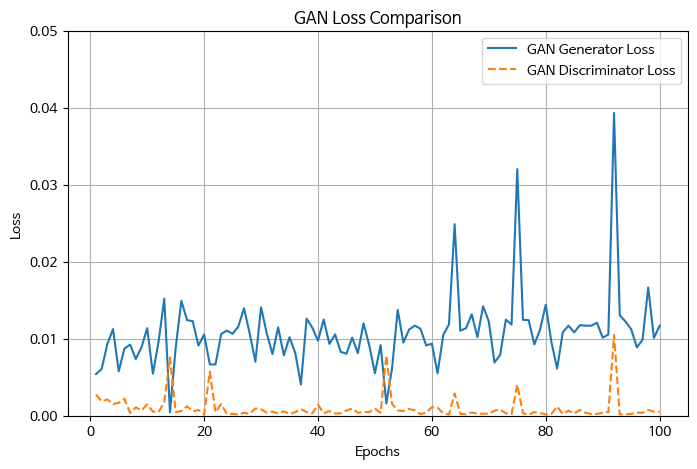

In [27]:
# GAN Generator, Discriminator 시각화
epochs = range(1, len(gan_Gloss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, gan_Gloss, linestyle='-', label="GAN Generator Loss")
plt.plot(epochs, gan_Dloss, linestyle='--', label="GAN Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Loss Comparison")
plt.ylim(0, 0.05)
plt.legend()
plt.grid(True)
plt.show()

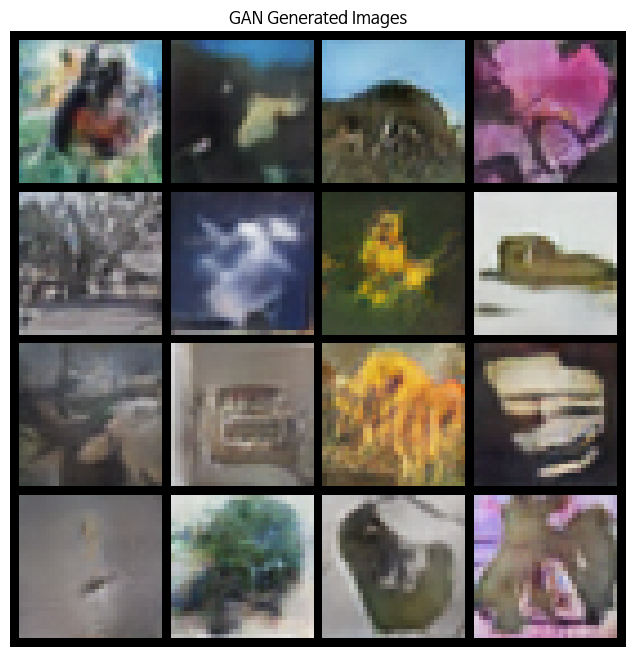

In [26]:
# 학습 결과 시각화
def generate_images(generator, num_images=16, latent_dim=100):
    generator.eval()
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise)
    fake_images = (fake_images + 1) / 2 # 이미지 정규화 해제
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("GAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2, normalize=False).permute(1, 2, 0))
    plt.show()

generate_images(gen)

# CGAN구현(Generator, Discriminiator, train)

In [8]:
class CGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_channels=3):
        super(CGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim * 2, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # (batch, latent_dim, 1, 1)
        z = torch.cat([z, label_input], dim=1)
        return self.model(z)

In [9]:
class CGANDiscriminator(nn.Module):
    def __init__(self, num_classes=100, img_channels=3):
        super(CGANDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, img_channels * 32 * 32)

        self.model = nn.Sequential(
            nn.Conv2d(img_channels * 2, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(labels.size(0), 3, 32, 32)
        img = torch.cat([img, label_input], dim=1)
        return self.model(img).view(-1, 1)

In [10]:
def train_cgan(generator, discriminator, dataloader, epochs=50, latent_dim=100, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    G_loss = []
    D_loss = []

    for epoch in range(epochs):
        for i, (real_images, labels) in enumerate(dataloader):
            batch_size = real_images.size(0)

            real_images, labels = real_images.to(device), labels.to(device)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            total_loss_G = 0
            total_loss_D = 0

            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images, labels)
            loss_real = criterion(real_outputs, real_labels)

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise, labels)
            fake_outputs = discriminator(fake_images.detach(), labels)
            loss_fake = criterion(fake_outputs, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images, labels)
            loss_G = criterion(fake_outputs, real_labels)
            loss_G.backward()
            optimizer_G.step()

            total_loss_G += loss_G.item()
            total_loss_D += loss_D.item()

        G_loss.append(total_loss_G / len(dataloader))
        D_loss.append(total_loss_D / len(dataloader))

        print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    return G_loss, D_loss

In [13]:
cgen = CGANGenerator()
cdis = CGANDiscriminator()
cgan_Gloss, cgan_Dloss = train_cgan(cgen, cdis, train_loader, epochs=100, latent_dim=100, lr=0.0002)

Epoch [1/100] Loss_D: 1.3457 Loss_G: 1.0734
Epoch [2/100] Loss_D: 0.9015 Loss_G: 2.4629
Epoch [3/100] Loss_D: 1.3275 Loss_G: 3.1260
Epoch [4/100] Loss_D: 1.0896 Loss_G: 2.9662
Epoch [5/100] Loss_D: 1.2039 Loss_G: 1.9951
Epoch [6/100] Loss_D: 1.1687 Loss_G: 4.9894
Epoch [7/100] Loss_D: 0.7620 Loss_G: 3.1547
Epoch [8/100] Loss_D: 0.4299 Loss_G: 2.5634
Epoch [9/100] Loss_D: 0.5696 Loss_G: 4.2384
Epoch [10/100] Loss_D: 0.3176 Loss_G: 3.4266
Epoch [11/100] Loss_D: 0.5988 Loss_G: 2.5851
Epoch [12/100] Loss_D: 0.1950 Loss_G: 2.9566
Epoch [13/100] Loss_D: 0.2589 Loss_G: 2.7976
Epoch [14/100] Loss_D: 0.2582 Loss_G: 2.8182
Epoch [15/100] Loss_D: 0.4954 Loss_G: 2.0428
Epoch [16/100] Loss_D: 0.0282 Loss_G: 7.2391
Epoch [17/100] Loss_D: 0.0623 Loss_G: 4.2360
Epoch [18/100] Loss_D: 0.1899 Loss_G: 5.1883
Epoch [19/100] Loss_D: 0.3703 Loss_G: 1.9112
Epoch [20/100] Loss_D: 0.5183 Loss_G: 1.9084
Epoch [21/100] Loss_D: 0.0498 Loss_G: 4.5952
Epoch [22/100] Loss_D: 0.4319 Loss_G: 2.8705
Epoch [23/100] Loss

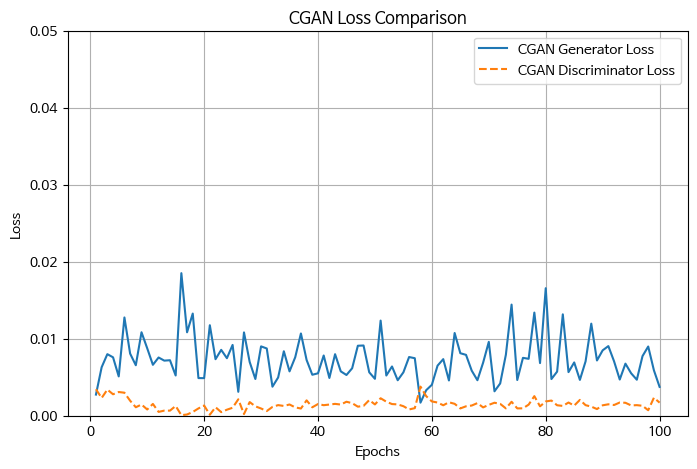

In [24]:
# CGAN Generator, Discriminator Loss 시각화
epochs = range(1, len(cgan_Gloss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, cgan_Gloss, linestyle='-', label="CGAN Generator Loss")
plt.plot(epochs, cgan_Dloss, linestyle='--', label="CGAN Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CGAN Loss Comparison")
plt.ylim(0, 0.05)
plt.legend()
plt.grid(True)
plt.show()

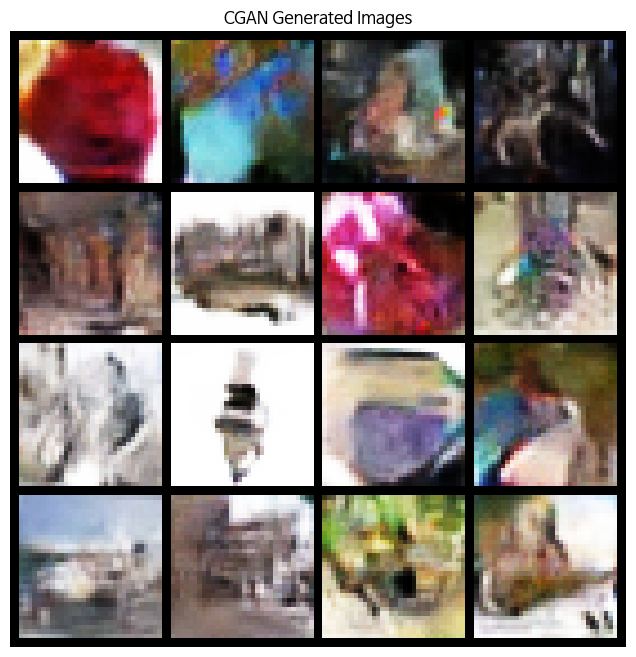

In [25]:
def generate_cgan_images(generator, num_classes=16, latent_dim=100):
    generator.eval()
    noise = torch.randn(num_classes, latent_dim, 1, 1, device=device)
    labels = torch.arange(0, num_classes, device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels)
    fake_images = (fake_images + 1) / 2
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("CGAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2, normalize=False).permute(1, 2, 0))
    plt.show()
generate_cgan_images(cgen)


# 보고서

## 1. CIFAR100 데이터셋

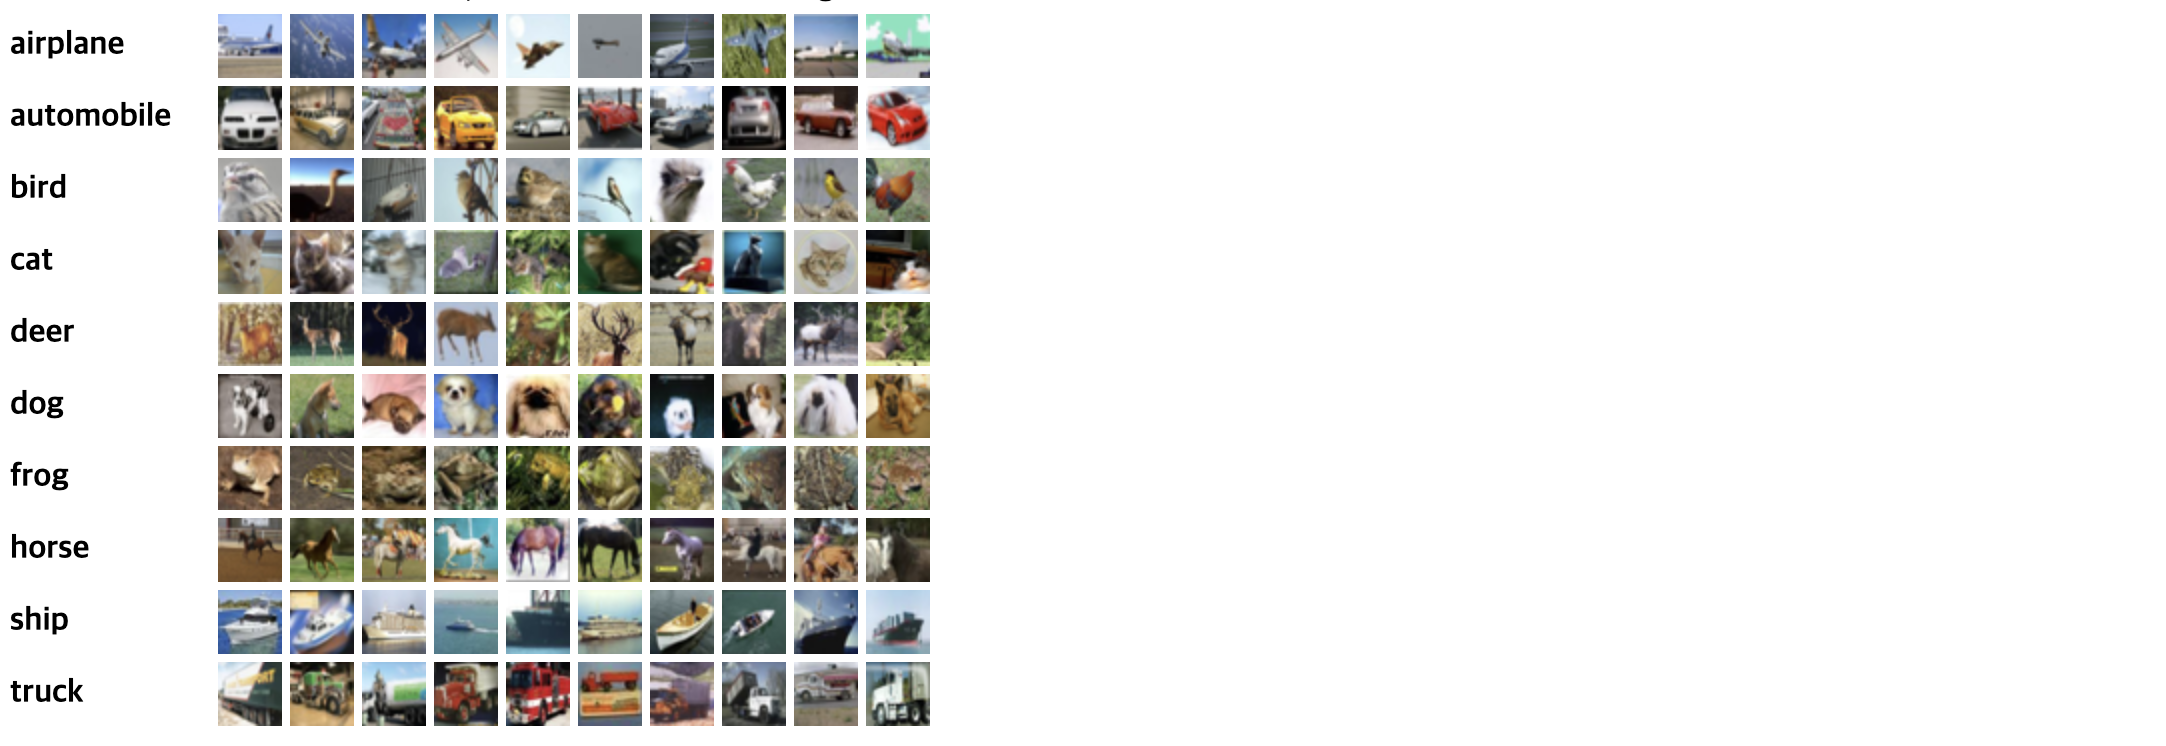

- 링크 : https://www.cs.toronto.edu/~kriz/cifar.html
- 100개의 클래스로 이루어진 총 60,000장의 32X32 RGB 이미지
- 데이터셋 크기
    - 학습 데이터 : 50,000장
    - 테스트 데이터 : 10,000장

## 2. 실험 과정
- GAN모델
    - 노이즈로 이미지를 만드는 generator와 generator가 만드는 이미지가 실제 이미지인지 아닌지 판단하는 discriminator의 경쟁을 통해 학습이 이루어진다.
    - 우선 discriminator는 실제 이미지를 입력으로 받아 나온 결과값을 정답 라벨값(1)과 비교하여 지금 학습하는 이미지가 진짜 이미지라는 것을 학습한다.
    - generator는 1X1의 이미지를 입력으로 받고 데이터셋 이미지의 크기만큼 크기를 늘려주며 이미지를 생성하고, 오답 라벨값(0)과 함께 discriminator에게 지금 학습하는 이미지가 가짜 이미지라는 것을 학습시킨다.
    - 이렇게 생성된 이미지를 discriminator에 다시 넣어 그 Loss값을 이용해 generator를 학습시킨다.
- CGAN모델
    - Conditional GAN모델로 구조는 거의 비슷하지만 입력값에 실제 이미지의 다른 조건을 추가하여 생성하는 이미지를 제어할 수 있는 방법이다. 이 과제에서는 이미지의 label값이 포함되었다.
    - 임베딩, 원 핫 벡터를 통해 조건정보를 만들고 입력데이터에 추가로 넣어 조건을 학습하도록 도와준다.
- DCGAN
    - 기존 GAN모델은 MLP를 이용해 이미지를 1d벡터로 변환하여 이미지 픽셀만큼 FC레이어를 늘려 학습하지만 DCGAN은 Convolution연산을 이용한 확장을 통해 이미지를 생성하기 때문에 공간적 정보가 더 잘 유지되고 필터를 학습하므로 연산 속도가 빠르다는 장점이 있다.


## 3. 실험 결과

### GAN

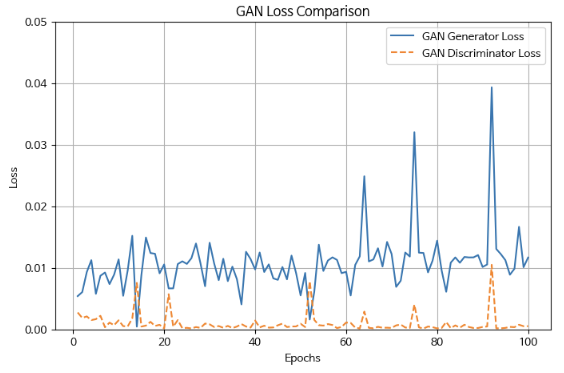

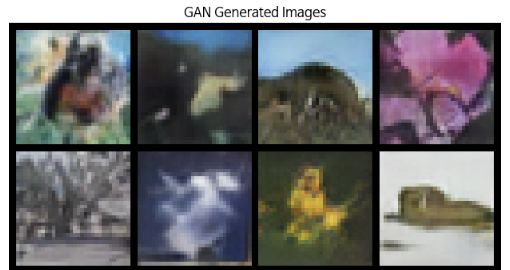

### CGAN

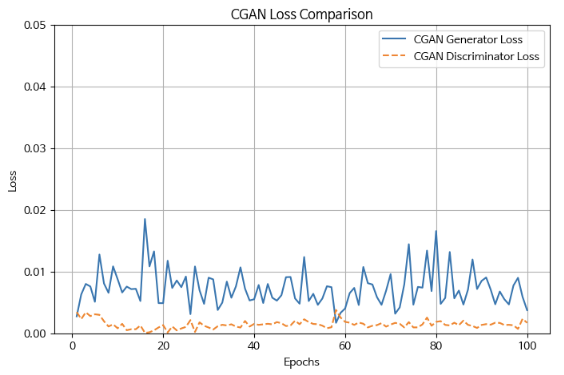

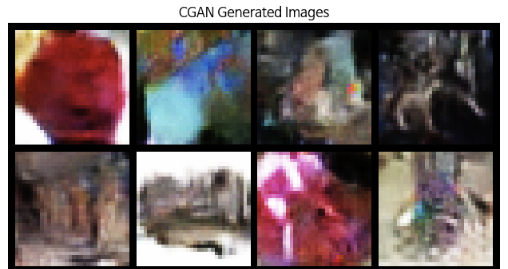

## 4. 실험 분석 및 고찰

- 전체적으로 노이즈가 심한 Loss값을 보여주지만 CGAN모델이 GAN모델보다 학습이 더 안정적으로 되었다는 특징이 있다.
    - 100종류의 클래스로 이루어진 데이터셋이니만큼 클래스 별로 공통적인 지역적 특징이 존재하기 때문에 클래스로 나누어 학습시킨 CGAN이 더 안정적인 학습이 가능할 것이라 예상했다.
- CGAN모델 Condition 학습 방식의 차이
    - CGAN모델 에서는 원핫벡터를 이용해 Condition을 학습하는 방법과 임베딩을 이용해 학습하는 방식이 있음
    - 이번 과제에서는 임베딩을 이용해 라벨을 연속적 벡터공간으로 만들어 학습하는데, 이는 라벨 간 관계에 영향을 받는다. 만약 전혀 다른 클래스인데 임베딩이 학습이 진행되며 비슷하다고 판단하여 서로의 특징을 반영하는 생성이 이루어질 수도 있다.
    - CelabA와 같은 경우 모두 사람의 얼굴이기에 Condition을 반영할 때 라벨 간 관계에 영향을 받아도 괜찮다고 생각하지만 비행기, 사과, 고양이와 같이 상관 없는 라벨값이 모여있는 데이터의 경우 CGAN을 이용할 때, Condition정보를 원 핫 벡터로 만드는 것이 더 나을 수 있다고 판단했다.
- 데이터 증강의 필요성
    - 처음 과제를 진행할 때, 생성한 이미지와, 데이터로더의 이미지를 이용해 Loss값을 계산한다고 잘못 생각하고 정규화만 진행한 후 학습을 진행했지만, 정확한 학습 과정을 알게 된 후 다양한 데이터 증강을 진행한 이미지로 discriminator를 학습하면 더욱 일반적인 특징을 학습할 수 있을 것이라고 생각한다.